# Group work aCRM

#### Imports

In [85]:
# !pip install tensorflow

In [86]:
from tqdm import tqdm
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
from numpy import *
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [229]:
print(tf.__version__)

2.0.0


#### Modules, functions, ...

In [87]:
# Clean security_deposit  
def clean_dollar(df, feature):   
    try: 
        df[feature] = df[feature].str.replace("$","")
        df[feature] = df[feature].str.replace(",","")
        df[feature]  = pd.to_numeric(df[feature], downcast = 'float')
    except: 
        print("already converted")

In [88]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    y_pos = np.arange(start, len(time) , 31)
    plt.plot(time, series)
    plt.xticks(y_pos, time[y_pos], rotation = 'vertical')
    plt.xlabel("Date")
    plt.ylabel("Price")
    
def plot_series2(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.plot(time, series)
    plt.xlabel("Date")
    plt.ylabel("Price")
    


## Loading data

In [89]:
try: 
    # Paden Joran 
    calendar_detail = pd.read_csv("calendar_detail.csv")
    listings_detail = pd.read_csv("listings_detail.csv")
    listings_summary = pd.read_csv("listings_summary.csv")
    neighbourhoods = pd.read_csv("neighbourhoods.csv")
    reviews_detail = pd.read_csv("reviews_detail.csv")
    reviews_summary = pd.read_csv("reviews_summary.csv")
    with open('neighbourhoods.geojson') as f:
        neighbourhoods_geojson = json.load(f)
except: 
    print("Files not found")

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [90]:
cal_det_available = calendar_detail[calendar_detail['available'] == 't']
try: 
    cal_det_available['price'] = cal_det_available['price'].str.replace("$","")
    cal_det_available['price'] = cal_det_available['price'].str.replace(",","")
    cal_det_available.price = pd.to_numeric(cal_det_available.price, downcast = 'float')
except: 
    print("Already converted")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

#### Plot how the average price evolves through the year across New York.

In [97]:
cal_det_available.price.describe()

count    5.582376e+06
mean     1.704162e+02
std      2.575613e+02
min      1.000000e+01
25%      7.200000e+01
50%      1.150000e+02
75%      1.990000e+02
max      2.000000e+04
Name: price, dtype: float64

In [98]:
df = cal_det_available.groupby('date').mean()['price']
av_price_ny = pd.DataFrame({
    'date' : df.keys().tolist(),
    'average_price' : df.tolist()
})
av_price_ny.head(2)

# Sort (voor de zekerheid)
av_price_ny = av_price_ny.sort_values('date', ascending = True)

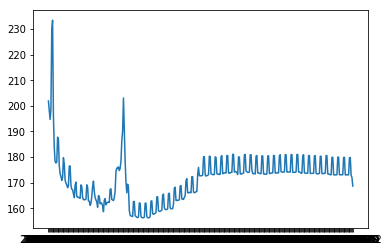

In [99]:
# Plot 
height = av_price_ny.average_price
bars = av_price_ny.date
y_pos = np.arange(len(bars))
plt.plot(bars, height)
plt.xticks(y_pos, bars)
plt.show()

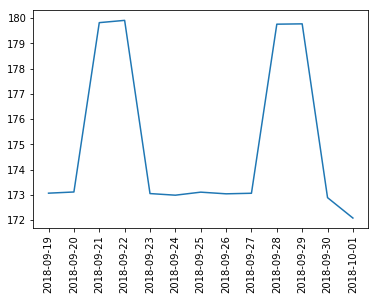

In [100]:
# Plot 10 latest data 
height = av_price_ny.average_price[-14:-1]
bars = av_price_ny.date[-14:-1]
y_pos = np.arange(len(bars))
plt.plot(bars, height)
plt.xticks(y_pos, bars, rotation = 'vertical')
plt.show()



## Heuristic approach

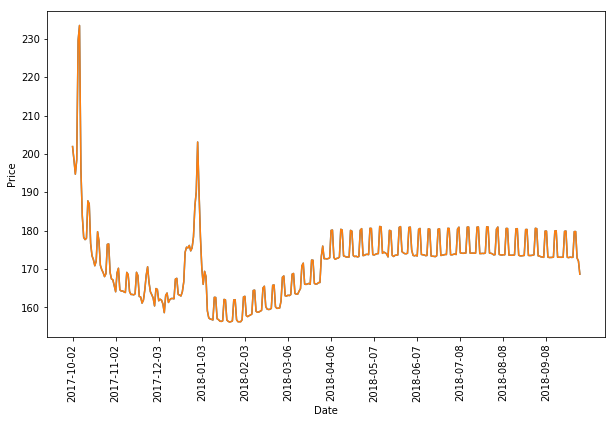

In [101]:
time = av_price_ny.date
series = av_price_ny.average_price

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

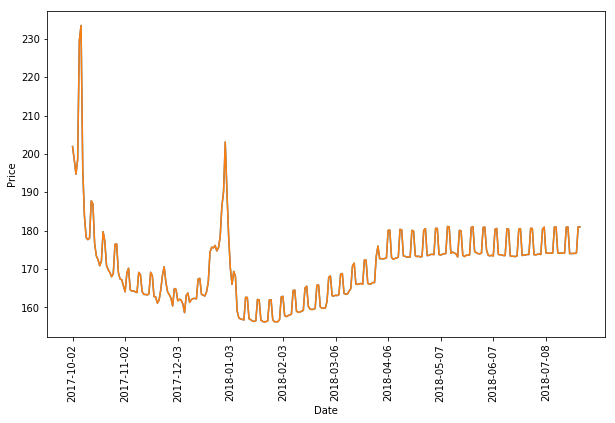

In [106]:
# Split in training and testing and plot both
split_time = 300
time_train = time[:split_time].values
x_train = series[:split_time].values
time_valid = time[split_time:].values
x_valid = series[split_time:].values
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

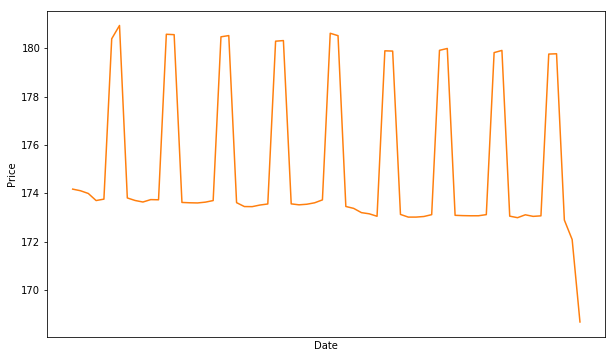

In [107]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start = split_time)
plt.show()

#### Naive forecast

In [108]:
# Take the current value as the next value
naive_forecast = series[split_time - 1:-1]

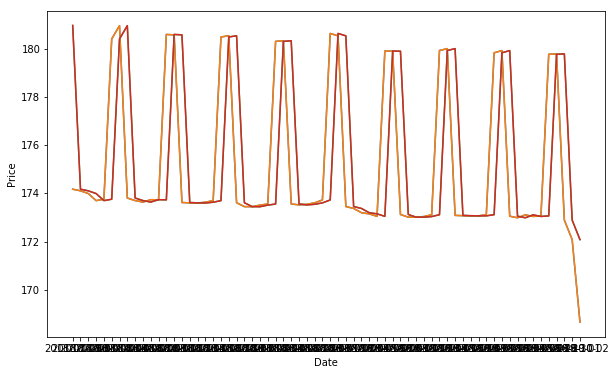

In [109]:
# Observe the accuracy
plt.figure(figsize=(10, 6))
plot_series2(time_valid, x_valid)
plot_series2(time_valid, naive_forecast)

This will be our baseline

In [110]:
# Compute MSE and MAE 
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

13.682014
2.0846035


MAE of 2 is actually pretty low, but the data also only fluctuates by a maximum of roughly 6 units. Therefore, having an MAE of 2 is 33% of the total fluctuation which is not that great

#### Approaching with a moving average

In [111]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

mse for MA with 2 variables is: 17.288447442939894
mae for MA with 2 variables is: 3.076531034527403 

mse for MA with 3 variables is: 17.16756217604737
mae for MA with 3 variables is: 3.4117472484858364 

mse for MA with 4 variables is: 16.696122489701366
mae for MA with 4 variables is: 3.551268433079575 

mse for MA with 5 variables is: 16.029750222432927
mae for MA with 5 variables is: 3.6031649040453346 



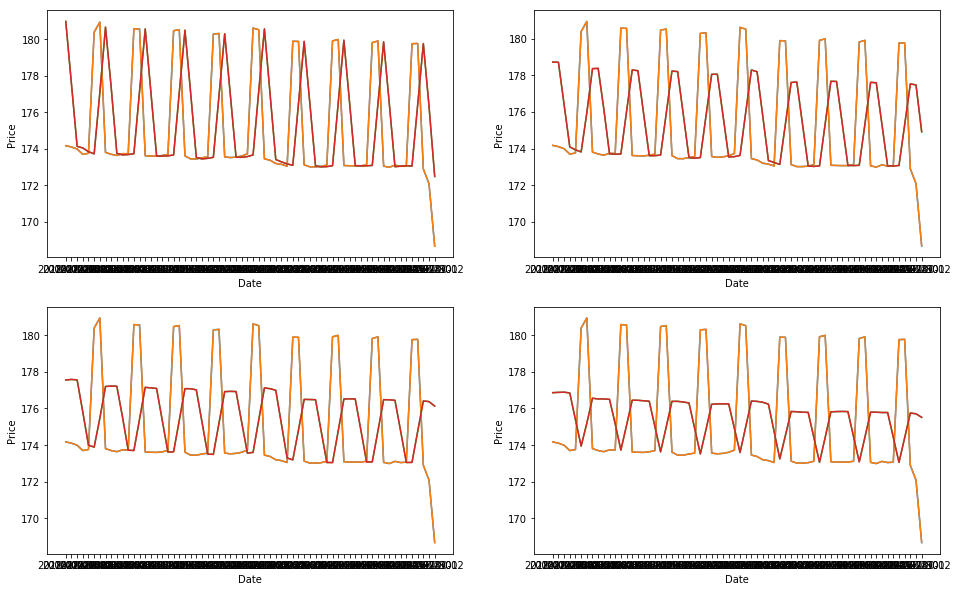

In [112]:
moving_averages = [2,3,4,5]
plt.figure(figsize=(16, 10))
for i in range(0,len(moving_averages)):
    MAV = moving_averages[i]
    moving_avg = moving_average_forecast(series, MAV)[split_time - MAV:]
    plt.subplot(2,2,i+1)
    plot_series2(time_valid, x_valid)
    plot_series2(time_valid, moving_avg)
    mse = keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
    print('mse for MA with %s variables is:' %MAV, mse)
    mae = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
    print('mae for MA with %s variables is:' %MAV, mae , '\n')

Clearly, we would have to set a very sensitive time window to get somewhat decent values for our predictions. When the window is set too high, we can even get a pattern that is entirely opposite to the original pattern

#### Trying to remove the seasonality from the Moving Average and recompute

The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 7 days, we will subtract the value at time t – 7 from the value at time t.

In [113]:
series = np.array(series)
time = np.array(time)

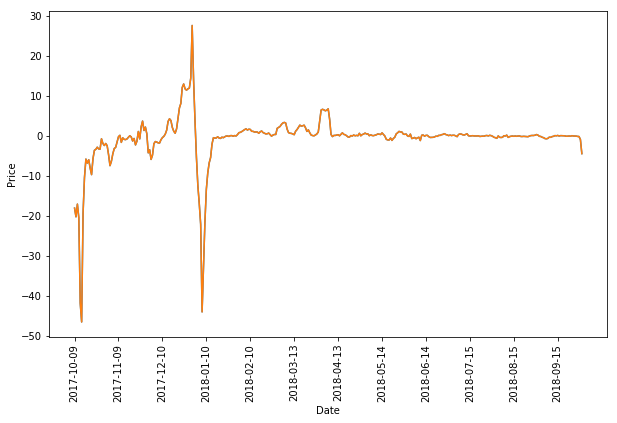

In [114]:
diff_series = (series[7:] - series[:-7])
diff_time = time[7:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Except from the irregularities in the beginning (which we already saw on prefious plots),
We can really see that we quite succeeded in removing the seasonality at the end of the timeline

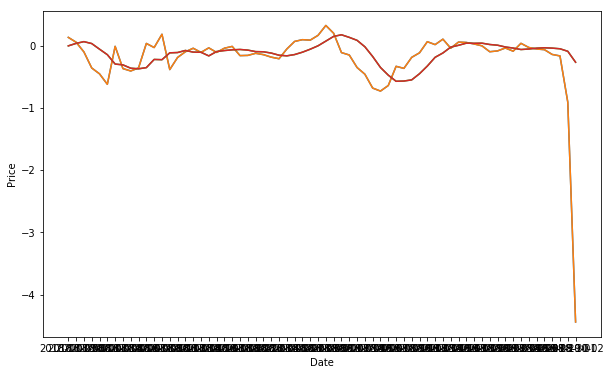

In [115]:
diff_moving_avg = moving_average_forecast(diff_series, 5)[split_time - 7 - 5:]

plt.figure(figsize=(10, 6))
plot_series2(time_valid, diff_series[split_time - 7:])
plot_series2(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

In [116]:
def plot_series3(time, series, format="-", start=0, end=None, jumps=7):
    plt.plot(time[start:end], series[start:end], format)
    x_pos = np.arange(0, len(time),7)
    plt.plot(time, series)
    plt.xticks(x_pos, time[x_pos], rotation = 75)
    plt.xlabel("Date")
    plt.ylabel("Price")

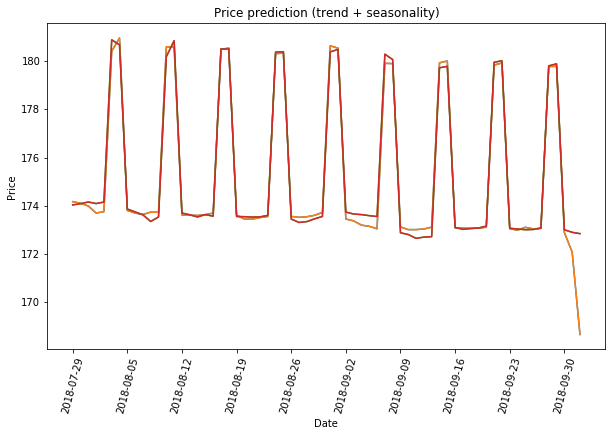

In [117]:
# plot
diff_moving_avg_plus_past = series[split_time - 7:-7] + diff_moving_avg
plt.figure(figsize=(10, 6))
plot_series3(time_valid, x_valid)
plot_series3(time_valid, diff_moving_avg_plus_past)
plt.title('Price prediction (trend + seasonality)')

plt.show()

In [118]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

0.31972103108835304
0.23347838430693715


This looks already very promising! Yet, we chose a window size of 5 (arbitrary). This is a very short window size to make predictions on and therefore, this might be very vulnerable to eventual price changes. Therefore, let's see if we can approximate this accuracy with a neural network. 

## Single Layer Neural Network

In [119]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [120]:
# Choose hyperparameters 
window_size = 7  # Since we saw a seasonal pattern of 7 days
batch_size = 14  # Take this as a multiple of 7 for good measure
shuffle_buffer_size = 100

In [121]:
# Define, compile and fit the NN 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# The neural network (only 1 layer)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

model = tf.keras.models.Sequential([l0])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.24045026],
       [ 0.52520704],
       [-0.05471445],
       [ 0.00597124],
       [ 0.0648073 ],
       [-0.03135068],
       [ 0.75073373]], dtype=float32), array([0.00226291], dtype=float32)]


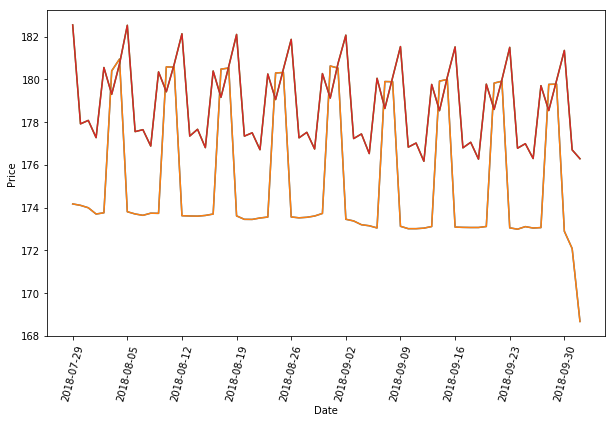

In [123]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series3(time_valid, x_valid)
plot_series3(time_valid, results)

In [124]:
print('mse: ', keras.metrics.mean_squared_error(x_valid, results).numpy())
print('mae: ',keras.metrics.mean_absolute_error(x_valid, results).numpy())

mse:  24.065891
mae:  4.0874157


As can be seen, the performance is very low. We actually have a very high MAE here.
Yet, multiple causes might be at hand here:

1. The irregular behaviour of the price in the beginning of the period messes up the neurons 
2. The Single Layer NN is not enough to predict the values, we need to combine for example an LSTM or GRU to make use of their ability to carry values from the past and future throughout the network. 
3. The hyperparameters were wrongly set
4. ...


## DNN (Deep Neural Network) 

In [125]:
# Clear session
tf.keras.backend.clear_session()

In [126]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [127]:
# Choose hyperparameters 
window_size = 7  # Since we saw a seasonal pattern of 7 days
batch_size = 14  # Take this as a multiple of 7 for good measure
shuffle_buffer_size = 100

In [128]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=1000,verbose=0)

Text(0.5, 1.0, 'Deep learning network (3 layers)')

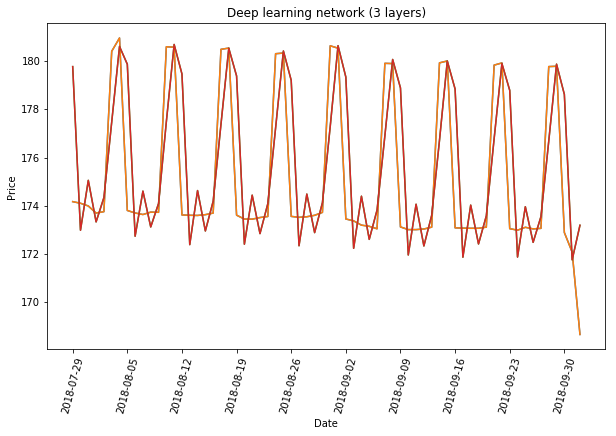

In [129]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series3(time_valid, x_valid)
plot_series3(time_valid, results)
plt.title('Deep learning network (3 layers)')

In [130]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.8266973

In [131]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 30000]

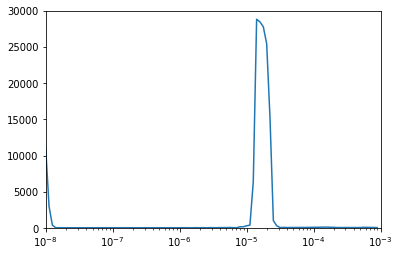

In [142]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30000])

Probably the behaviour is so strange because of the weird behaviour in the beginning of the dataset.

The learning rate is really hard to optimmize

In [133]:
# Clear session
tf.keras.backend.clear_session()

In [134]:
# Choose hyperparameters 
window_size = 7  # Since we saw a seasonal pattern of 7 days
batch_size = 14  # Take this as a multiple of 7 for good measure
shuffle_buffer_size = 100

In [135]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

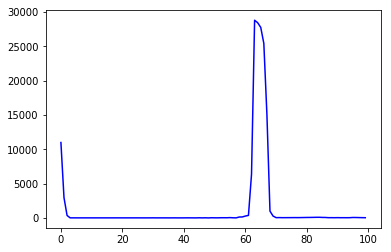

In [136]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [138]:
# Doesn't really go smoothly, so a lot of work still has to be done (e.g. cutting away the beginning of the dataset )

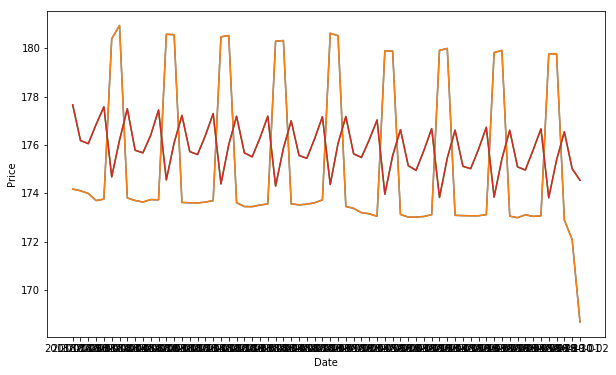

In [139]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series2(time_valid, x_valid)
plot_series2(time_valid, results)

Doesn't really improve the performance. A learning rate of 10^-6 seemed a better option

In [140]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.5533187

##### 1. Cutting away part of the dataset

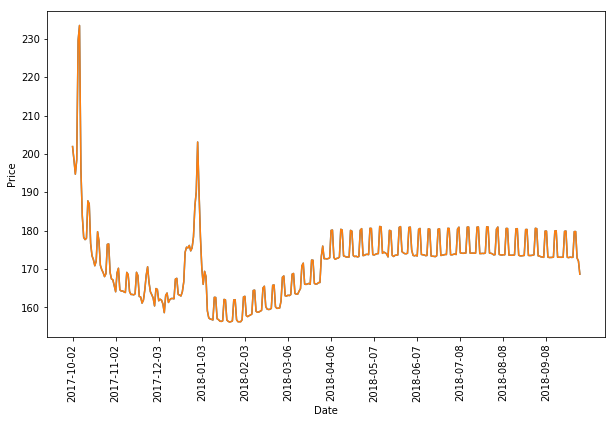

In [143]:
# Reminder to how the dataset looked like: 
tf.keras.backend.clear_session()
time = av_price_ny.date
series = av_price_ny.average_price

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Two possible decisions could be made here:

1. Cut away the early values until the last spike at 2017-12-31
2. Cut away until around 2018-03-31 

Since there is not really a lot of data (1 year), we intend to go for the 1st option and keep as much data as possible

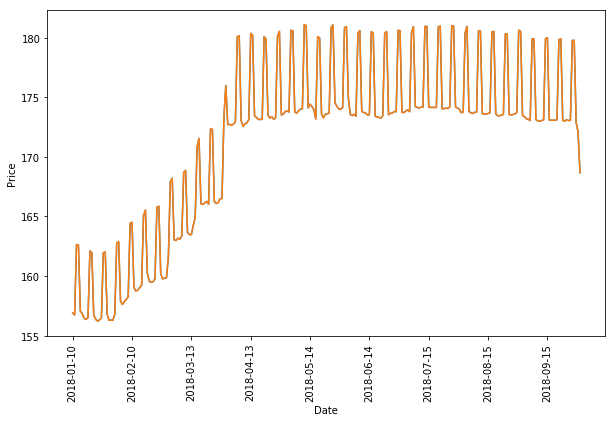

In [144]:
# Reminder to how the dataset looked like: 
time = time[100:].values
series = series[100:].values

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [145]:
# Clear session
tf.keras.backend.clear_session()

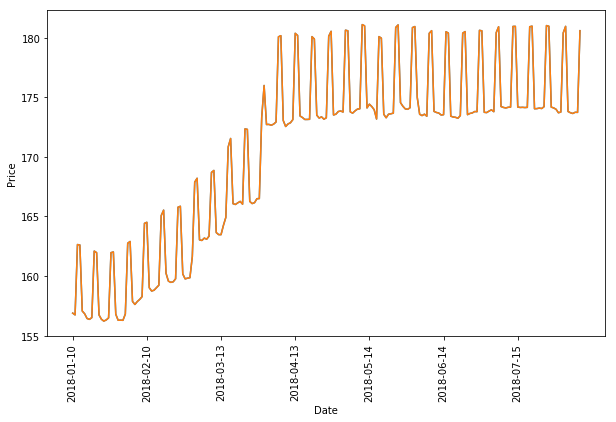

In [146]:
# Split in training and testing and plot training
split_time = round(len(time)*0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

In [147]:
# Retrain and re-evaluate

# Choose hyperparameters 
window_size = 7  # Since we saw a seasonal pattern of 7 days
batch_size = 14  # Take this as a multiple of 7 for good measure
shuffle_buffer_size = 20

In [149]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000
15/15 [==============================]: 48791.39 - 0s 115ms/step - loss: 33600.01 - 0s 78ms/step - loss: 25377.3721 - 0s 60ms/step - loss: 19592.782 - 0s 49ms/step - loss: 15765.136 - 0s 42ms/step - loss: 14417.409 - 0s 37ms/step - loss: 13652.855 - 0s 33ms/step - loss: 12114.813 - 0s 30ms/step - loss: 10842.286 - 0s 27ms/step - loss: 10197.565 - 0s 26ms/step - loss: 9871.469 - 0s 24ms/step - loss: 9571.10 - 0s 23ms/step - loss: 9083.15 - 0s 21ms/step - loss: 8448.55 - 0s 20ms/step - loss: 7966.11 - 0s 22ms/step - loss: 7966.1100
Epoch 2/1000
15/15 [==============================] - ETA: 0s - loss: 3346.62 - 0s 5ms/step - loss: 1083.6805
Epoch 3/1000
15/15 [==============================] - ETA: 0s - loss: 552.437 - 0s 6ms/step - loss: 216.1232
Epoch 4/1000
15/15 [==============================] - ETA: 0s - loss: 90.19 - 0s 5ms/step - loss: 42.6429
Epoch 5/1000
15/15 [==============================] - ETA: 0s - loss: 16.29 - 0s 5ms/step - loss: 17.5654
Epoch 6/1000
15/15 [

Epoch 74/1000
15/15 [==============================] - ETA: 0s - loss: 5.395 - 0s 4ms/step - loss: 6.8223
Epoch 75/1000
15/15 [==============================] - ETA: 0s - loss: 4.652 - 0s 4ms/step - loss: 6.9891
Epoch 76/1000
15/15 [==============================] - ETA: 0s - loss: 5.220 - 0s 4ms/step - loss: 8.0951
Epoch 77/1000
15/15 [==============================] - ETA: 0s - loss: 4.940 - 0s 4ms/step - loss: 7.9627
Epoch 78/1000
15/15 [==============================] - ETA: 0s - loss: 4.933 - 0s 4ms/step - loss: 7.5876
Epoch 79/1000
15/15 [==============================] - ETA: 0s - loss: 2.747 - 0s 4ms/step - loss: 6.6782
Epoch 80/1000
15/15 [==============================] - ETA: 0s - loss: 5.583 - 0s 4ms/step - loss: 6.8227
Epoch 81/1000
15/15 [==============================] - ETA: 0s - loss: 4.197 - 0s 5ms/step - loss: 7.7534
Epoch 82/1000
15/15 [==============================] - ETA: 0s - loss: 6.944 - 0s 6ms/step - loss: 6.7491
Epoch 83/1000
15/15 [=========================

15/15 [==============================] - ETA: 0s - loss: 2.974 - 0s 4ms/step - loss: 4.0202
Epoch 226/1000
15/15 [==============================] - ETA: 0s - loss: 4.081 - 0s 4ms/step - loss: 3.8644
Epoch 227/1000
15/15 [==============================] - ETA: 0s - loss: 2.335 - 0s 5ms/step - loss: 3.9783
Epoch 228/1000
15/15 [==============================] - ETA: 0s - loss: 2.772 - 0s 4ms/step - loss: 3.8290
Epoch 229/1000
15/15 [==============================] - ETA: 0s - loss: 3.416 - 0s 5ms/step - loss: 4.1735
Epoch 230/1000
15/15 [==============================] - ETA: 0s - loss: 1.311 - 0s 4ms/step - loss: 3.8255
Epoch 231/1000
15/15 [==============================] - ETA: 0s - loss: 1.610 - 0s 4ms/step - loss: 3.7407
Epoch 232/1000
15/15 [==============================] - ETA: 0s - loss: 2.663 - 0s 4ms/step - loss: 4.2483
Epoch 233/1000
15/15 [==============================] - ETA: 0s - loss: 3.366 - 0s 5ms/step - loss: 3.9284
Epoch 234/1000
15/15 [==============================

15/15 [==============================] - ETA: 0s - loss: 1.267 - 0s 4ms/step - loss: 2.7141
Epoch 377/1000
15/15 [==============================] - ETA: 0s - loss: 2.068 - 0s 4ms/step - loss: 3.3472
Epoch 378/1000
15/15 [==============================] - ETA: 0s - loss: 1.144 - 0s 4ms/step - loss: 2.4347
Epoch 379/1000
15/15 [==============================] - ETA: 0s - loss: 0.965 - 0s 4ms/step - loss: 2.5530
Epoch 380/1000
15/15 [==============================] - ETA: 0s - loss: 1.661 - 0s 4ms/step - loss: 2.7094
Epoch 381/1000
15/15 [==============================] - ETA: 0s - loss: 1.378 - 0s 4ms/step - loss: 2.6683
Epoch 382/1000
15/15 [==============================] - ETA: 0s - loss: 0.946 - 0s 4ms/step - loss: 2.7138
Epoch 383/1000
15/15 [==============================] - ETA: 0s - loss: 2.163 - 0s 4ms/step - loss: 2.4281
Epoch 384/1000
15/15 [==============================] - ETA: 0s - loss: 1.337 - 0s 4ms/step - loss: 3.2650
Epoch 385/1000
15/15 [==============================

15/15 [==============================] - ETA: 0s - loss: 0.956 - 0s 5ms/step - loss: 1.8406
Epoch 529/1000
15/15 [==============================] - ETA: 0s - loss: 0.701 - 0s 5ms/step - loss: 2.0938
Epoch 530/1000
15/15 [==============================] - ETA: 0s - loss: 0.991 - 0s 6ms/step - loss: 2.4255
Epoch 531/1000
15/15 [==============================] - ETA: 0s - loss: 0.706 - 0s 4ms/step - loss: 1.9597
Epoch 532/1000
15/15 [==============================] - ETA: 0s - loss: 0.852 - 0s 4ms/step - loss: 2.6321
Epoch 533/1000
15/15 [==============================] - ETA: 0s - loss: 1.746 - 0s 4ms/step - loss: 2.2302
Epoch 534/1000
15/15 [==============================] - ETA: 0s - loss: 0.724 - 0s 4ms/step - loss: 1.9419
Epoch 535/1000
15/15 [==============================] - ETA: 0s - loss: 0.998 - 0s 4ms/step - loss: 1.8552
Epoch 536/1000
15/15 [==============================] - ETA: 0s - loss: 0.526 - 0s 4ms/step - loss: 2.3910
Epoch 537/1000
15/15 [==============================

15/15 [==============================] - ETA: 0s - loss: 0.967 - 0s 4ms/step - loss: 2.6484
Epoch 681/1000
15/15 [==============================] - ETA: 0s - loss: 0.842 - 0s 4ms/step - loss: 1.7142
Epoch 682/1000
15/15 [==============================] - ETA: 0s - loss: 0.860 - 0s 4ms/step - loss: 1.8386
Epoch 683/1000
15/15 [==============================] - ETA: 0s - loss: 0.748 - 0s 6ms/step - loss: 2.2317
Epoch 684/1000
15/15 [==============================] - ETA: 0s - loss: 1.157 - 0s 6ms/step - loss: 1.8749
Epoch 685/1000
15/15 [==============================] - ETA: 0s - loss: 0.948 - 0s 5ms/step - loss: 2.1606
Epoch 686/1000
15/15 [==============================] - ETA: 0s - loss: 0.971 - 0s 5ms/step - loss: 1.7487
Epoch 687/1000
15/15 [==============================] - ETA: 0s - loss: 0.712 - ETA: 0s - loss: 2.097 - 0s 7ms/step - loss: 1.9408
Epoch 688/1000
15/15 [==============================] - ETA: 0s - loss: 0.631 - 0s 6ms/step - loss: 2.2024
Epoch 689/1000
15/15 [======

Epoch 755/1000
15/15 [==============================] - ETA: 0s - loss: 1.477 - 0s 4ms/step - loss: 2.4337
Epoch 756/1000
15/15 [==============================] - ETA: 0s - loss: 1.428 - 0s 5ms/step - loss: 2.1119
Epoch 757/1000
15/15 [==============================] - ETA: 0s - loss: 0.932 - 0s 4ms/step - loss: 1.8229
Epoch 758/1000
15/15 [==============================] - ETA: 0s - loss: 0.919 - 0s 4ms/step - loss: 1.9600
Epoch 759/1000
15/15 [==============================] - ETA: 0s - loss: 1.450 - 0s 4ms/step - loss: 2.1900
Epoch 760/1000
15/15 [==============================] - ETA: 0s - loss: 1.245 - 0s 4ms/step - loss: 1.9926
Epoch 761/1000
15/15 [==============================] - ETA: 0s - loss: 0.501 - 0s 4ms/step - loss: 1.8069
Epoch 762/1000
15/15 [==============================] - ETA: 0s - loss: 0.707 - 0s 4ms/step - loss: 1.8527
Epoch 763/1000
15/15 [==============================] - ETA: 0s - loss: 0.739 - 0s 4ms/step - loss: 1.8261
Epoch 764/1000
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 1.134 - 0s 4ms/step - loss: 2.2499
Epoch 908/1000
15/15 [==============================] - ETA: 0s - loss: 1.239 - 0s 4ms/step - loss: 2.0456
Epoch 909/1000
15/15 [==============================] - ETA: 0s - loss: 0.678 - 0s 4ms/step - loss: 1.8359
Epoch 910/1000
15/15 [==============================] - ETA: 0s - loss: 0.796 - 0s 4ms/step - loss: 2.3253
Epoch 911/1000
15/15 [==============================] - ETA: 0s - loss: 1.128 - 0s 4ms/step - loss: 1.7198
Epoch 912/1000
15/15 [==============================] - ETA: 0s - loss: 0.518 - 0s 5ms/step - loss: 1.9550
Epoch 913/1000
15/15 [==============================] - ETA: 0s - loss: 0.530 - 0s 4ms/step - loss: 1.9295
Epoch 914/1000
15/15 [==============================] - ETA: 0s - loss: 1.185 - 0s 4ms/step - loss: 2.2764
Epoch 915/1000
15/15 [==============================] - ETA: 0s - loss: 0.979 - 0s 4ms/step - loss: 1.9807
Epoch 916/1000
15/15 [==============================

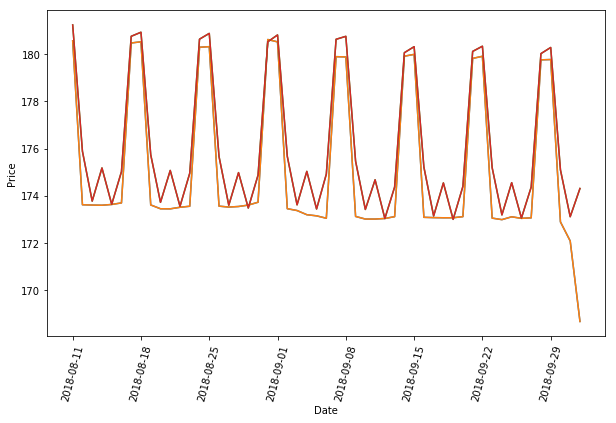

In [151]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series3(time_valid, x_valid)
plot_series3(time_valid, results)

In [152]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.0014418

We're getting there! Now, let's try to add an LSTM to try to mitigate the abberations in the forecast for the weekdays

# Adding an LSTM to the mix

In this part, we played a bit around with some LSTM's and convolutionals in an attempt to improve the accuracy. 

However, since the data only concerned a period of 1 year, it was rather hard to come up with a model that performs better than the DNN with 3 layers.

In [230]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [237]:
tf.keras.backend.clear_session()
tf.random.set_seed(21)
np.random.seed(21)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
15/15 [==============================]53.8480 - mae: 154.348 - 1s 657ms/step - loss: 154.6604 - mae: 155.16 - 1s 441ms/step - loss: 155.5728 - mae: 156.07 - 1s 333ms/step - loss: 156.5991 - mae: 157.09 - 1s 268ms/step - loss: 157.8881 - mae: 158.38 - 1s 225ms/step - loss: 159.4237 - mae: 159.92 - 1s 194ms/step - loss: 160.7698 - mae: 161.26 - 1s 171ms/step - loss: 161.8962 - mae: 162.39 - 1s 153ms/step - loss: 162.7194 - mae: 163.21 - 1s 139ms/step - loss: 163.4678 - mae: 163.96 - 1s 127ms/step - loss: 164.1643 - mae: 164.66 - 1s 117ms/step - loss: 164.7289 - mae: 165.22 - 1s 109ms/step - loss: 165.0537 - mae: 165.55 - 1s 102ms/step - loss: 165.4720 - mae: 165.97 - 1s 96ms/step - loss: 165.8022 - mae: 166.2125 - 1s 98ms/step - loss: 165.8022 - mae: 166.2125
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 154.6730 - mae: 155.173 - ETA: 0s - loss: 163.9633 - mae: 164.463 - 0s 8ms/step - loss: 165.3391 - mae: 165.9965
Epoch 3/100
15/15 [===================

15/15 [==============================] - ETA: 0s - loss: 4.3268 - mae: 4.798 - ETA: 0s - loss: 5.7725 - mae: 6.252 - 0s 7ms/step - loss: 5.4731 - mae: 5.8396
Epoch 89/100
15/15 [==============================] - ETA: 0s - loss: 21.3968 - mae: 21.896 - ETA: 0s - loss: 13.7660 - mae: 14.263 - 0s 8ms/step - loss: 13.9844 - mae: 14.3875
Epoch 90/100
15/15 [==============================] - ETA: 0s - loss: 18.6211 - mae: 19.121 - ETA: 0s - loss: 15.3836 - mae: 15.883 - 0s 7ms/step - loss: 15.2647 - mae: 15.3471
Epoch 91/100
15/15 [==============================] - ETA: 0s - loss: 14.0212 - mae: 14.521 - ETA: 0s - loss: 18.5604 - mae: 19.060 - 0s 7ms/step - loss: 18.8888 - mae: 19.3984
Epoch 92/100
15/15 [==============================] - ETA: 0s - loss: 30.1273 - mae: 30.627 - ETA: 0s - loss: 19.3056 - mae: 19.803 - 0s 8ms/step - loss: 19.5526 - mae: 20.2934
Epoch 93/100
15/15 [==============================] - ETA: 0s - loss: 38.3435 - mae: 38.843 - ETA: 0s - loss: 22.3524 - mae: 22.852 - 

[1e-08, 0.0001, 0, 200]

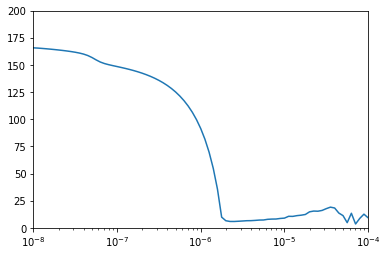

In [238]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 200])

In [245]:
8*1e-6

8e-06

In [246]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
15/15 [==============================] 19201.2285 - mae: 138.543 - 40s 20s/step - loss: 10290.0828 - mae: 87.776 - 40s 13s/step - loss: 10855.3863 - mae: 94.98 - 40s 10s/step - loss: 10299.5482 - mae: 94.44 - 40s 8s/step - loss: 10954.6282 - mae: 98.8345 - 40s 7s/step - loss: 10682.0610 - mae: 98.432 - 40s 6s/step - loss: 9591.2498 - mae: 92.230 - 40s 5s/step - loss: 8404.2211 - mae: 81.87 - 40s 4s/step - loss: 7598.4625 - mae: 76.52 - 40s 4s/step - loss: 7224.2261 - mae: 75.07 - 40s 4s/step - loss: 6986.0107 - mae: 74.41 - 41s 3s/step - loss: 6604.4650 - mae: 72.29 - 41s 3s/step - loss: 6102.9616 - mae: 67.39 - 41s 3s/step - loss: 5763.4029 - mae: 65.19 - 41s 3s/step - loss: 5628.7511 - mae: 64.99 - 41s 3s/step - loss: 5628.7511 - mae: 64.9933
Epoch 2/500
15/15 [==============================] - ETA: 0s - loss: 812.2806 - mae: 28.38 - ETA: 0s - loss: 529.7249 - mae: 20.15 - 0s 10ms/step - loss: 424.4193 - mae: 17.8372
Epoch 3/500
15/15 [==============================] - ET

Epoch 44/500
15/15 [==============================] - ETA: 0s - loss: 1285.4143 - mae: 35.765 - ETA: 0s - loss: 534.1322 - mae: 20.042 - 0s 7ms/step - loss: 485.8234 - mae: 19.4384
Epoch 45/500
15/15 [==============================] - ETA: 0s - loss: 1283.6348 - mae: 35.726 - ETA: 0s - loss: 533.3260 - mae: 20.107 - 0s 7ms/step - loss: 482.6780 - mae: 19.4820
Epoch 46/500
15/15 [==============================] - ETA: 0s - loss: 1219.4938 - mae: 34.783 - ETA: 0s - loss: 609.8160 - mae: 21.887 - ETA: 0s - loss: 473.6932 - mae: 18.72 - 0s 11ms/step - loss: 474.9266 - mae: 19.0445
Epoch 47/500
15/15 [==============================] - ETA: 0s - loss: 1260.9735 - mae: 35.417 - ETA: 0s - loss: 513.9441 - mae: 19.707 - 0s 8ms/step - loss: 466.0412 - mae: 19.0173
Epoch 48/500
15/15 [==============================] - ETA: 0s - loss: 1267.6158 - mae: 35.547 - ETA: 0s - loss: 519.7920 - mae: 19.615 - 0s 7ms/step - loss: 466.5413 - mae: 18.8153
Epoch 49/500
15/15 [==============================] - 

15/15 [==============================] - ETA: 0s - loss: 1225.2834 - mae: 34.903 - ETA: 0s - loss: 549.5711 - mae: 21.051 - 0s 8ms/step - loss: 450.1200 - mae: 18.6056
Epoch 135/500
15/15 [==============================] - ETA: 0s - loss: 1170.0439 - mae: 34.067 - ETA: 0s - loss: 507.5406 - mae: 19.690 - 0s 8ms/step - loss: 457.1677 - mae: 18.9340
Epoch 136/500
15/15 [==============================] - ETA: 0s - loss: 1275.7906 - mae: 35.647 - ETA: 0s - loss: 579.3706 - mae: 21.627 - 0s 9ms/step - loss: 479.1228 - mae: 19.2826
Epoch 137/500
15/15 [==============================] - ETA: 0s - loss: 1236.1326 - mae: 35.073 - ETA: 0s - loss: 630.6241 - mae: 22.926 - 0s 10ms/step - loss: 476.1800 - mae: 19.1832
Epoch 138/500
15/15 [==============================] - ETA: 0s - loss: 1276.9570 - mae: 35.637 - ETA: 0s - loss: 575.5597 - mae: 21.629 - 0s 9ms/step - loss: 478.2423 - mae: 19.3816
Epoch 139/500
15/15 [==============================] - ETA: 0s - loss: 1185.3953 - mae: 34.329 - ETA: 0

15/15 [==============================] - ETA: 0s - loss: 1249.6428 - mae: 35.218 - ETA: 0s - loss: 528.6913 - mae: 20.053 - 0s 8ms/step - loss: 478.3859 - mae: 19.3259
Epoch 225/500
15/15 [==============================] - ETA: 0s - loss: 1223.0651 - mae: 34.844 - ETA: 0s - loss: 531.5112 - mae: 20.184 - 0s 8ms/step - loss: 486.0960 - mae: 19.6425
Epoch 226/500
15/15 [==============================] - ETA: 0s - loss: 1243.6514 - mae: 35.162 - ETA: 0s - loss: 538.8555 - mae: 20.109 - 0s 7ms/step - loss: 488.4788 - mae: 19.5622
Epoch 227/500
15/15 [==============================] - ETA: 0s - loss: 1239.6741 - mae: 35.092 - ETA: 0s - loss: 492.1502 - mae: 19.324 - 0s 7ms/step - loss: 470.4092 - mae: 19.2552
Epoch 228/500
15/15 [==============================] - ETA: 0s - loss: 1178.5896 - mae: 34.213 - ETA: 0s - loss: 482.7374 - mae: 19.106 - 0s 8ms/step - loss: 434.8636 - mae: 18.4292
Epoch 229/500
15/15 [==============================] - ETA: 0s - loss: 1220.2970 - mae: 34.855 - ETA: 0s

15/15 [==============================] - ETA: 0s - loss: 1261.2745 - mae: 35.429 - ETA: 0s - loss: 508.0430 - mae: 19.420 - 0s 8ms/step - loss: 492.5541 - mae: 19.5433
Epoch 315/500
15/15 [==============================] - ETA: 0s - loss: 1245.2128 - mae: 35.216 - ETA: 0s - loss: 525.2467 - mae: 19.701 - 0s 8ms/step - loss: 474.3945 - mae: 19.1153
Epoch 316/500
15/15 [==============================] - ETA: 0s - loss: 1270.3341 - mae: 35.558 - ETA: 0s - loss: 523.6486 - mae: 19.867 - 0s 8ms/step - loss: 472.1954 - mae: 19.1128
Epoch 317/500
15/15 [==============================] - ETA: 0s - loss: 1238.2858 - mae: 35.079 - ETA: 0s - loss: 518.4261 - mae: 20.010 - 0s 7ms/step - loss: 474.8273 - mae: 19.5222
Epoch 318/500
15/15 [==============================] - ETA: 0s - loss: 1248.8380 - mae: 35.236 - ETA: 0s - loss: 529.0259 - mae: 19.926 - 0s 7ms/step - loss: 481.3537 - mae: 19.3213
Epoch 319/500
15/15 [==============================] - ETA: 0s - loss: 1204.9177 - mae: 34.590 - ETA: 0s

15/15 [==============================] - ETA: 0s - loss: 1266.4503 - mae: 35.499 - ETA: 0s - loss: 512.4302 - mae: 19.629 - 0s 8ms/step - loss: 463.2237 - mae: 18.8881
Epoch 405/500
15/15 [==============================] - ETA: 0s - loss: 1129.4883 - mae: 33.435 - ETA: 0s - loss: 471.8358 - mae: 18.799 - 0s 8ms/step - loss: 455.4911 - mae: 18.9815
Epoch 406/500
15/15 [==============================] - ETA: 0s - loss: 1228.1941 - mae: 34.940 - ETA: 0s - loss: 539.0429 - mae: 20.165 - 0s 8ms/step - loss: 492.3974 - mae: 19.5840
Epoch 407/500
15/15 [==============================] - ETA: 0s - loss: 1192.2732 - mae: 34.408 - ETA: 0s - loss: 518.7092 - mae: 19.882 - 0s 9ms/step - loss: 473.4776 - mae: 19.2731
Epoch 408/500
15/15 [==============================] - ETA: 0s - loss: 1253.8142 - mae: 35.292 - ETA: 0s - loss: 517.9172 - mae: 19.994 - 0s 8ms/step - loss: 471.3234 - mae: 19.4033
Epoch 409/500
15/15 [==============================] - ETA: 0s - loss: 1298.9795 - mae: 35.977 - ETA: 0s

15/15 [==============================] - ETA: 0s - loss: 1250.9310 - mae: 35.309 - ETA: 0s - loss: 563.4365 - mae: 21.543 - 0s 9ms/step - loss: 464.5530 - mae: 19.1587
Epoch 495/500
15/15 [==============================] - ETA: 0s - loss: 1211.1158 - mae: 34.692 - ETA: 0s - loss: 467.2439 - mae: 18.603 - 0s 7ms/step - loss: 456.1479 - mae: 18.8417
Epoch 496/500
15/15 [==============================] - ETA: 0s - loss: 1225.7396 - mae: 34.916 - ETA: 0s - loss: 484.6499 - mae: 19.154 - 0s 7ms/step - loss: 475.1371 - mae: 19.4600
Epoch 497/500
15/15 [==============================] - ETA: 0s - loss: 1274.2448 - mae: 35.614 - ETA: 0s - loss: 480.0641 - mae: 18.927 - 0s 7ms/step - loss: 478.7307 - mae: 19.2441
Epoch 498/500
15/15 [==============================] - ETA: 0s - loss: 1222.6598 - mae: 34.828 - ETA: 0s - loss: 467.1952 - mae: 18.862 - 0s 7ms/step - loss: 466.1879 - mae: 19.0400
Epoch 499/500
15/15 [==============================] - ETA: 0s - loss: 1215.6044 - mae: 34.723 - ETA: 0s

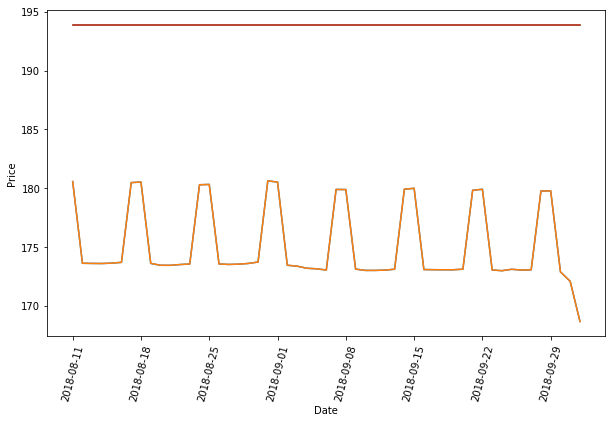

In [247]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series3(time_valid, x_valid)
plot_series3(time_valid, results)

<Figure size 432x288 with 0 Axes>

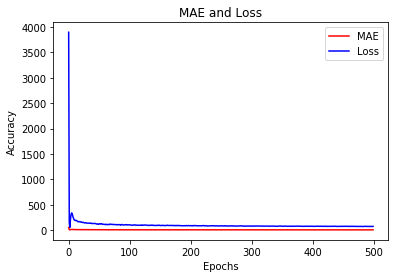

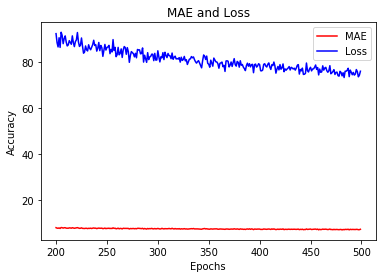

<Figure size 432x288 with 0 Axes>

In [211]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [212]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.1916888

# Adding LSTM to the mix

In [213]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [214]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
2/2 [==============================] 204.4129 - mae: 204.912 - 5s 3s/step - loss: 207.7277 - mae: 206.905 - 5s 3s/step - loss: 207.7277 - mae: 206.9054
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 204.4055 - mae: 204.905 - 0s 64ms/step - loss: 205.3301 - mae: 206.7547
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 204.0151 - mae: 204.515 - 0s 57ms/step - loss: 204.9819 - mae: 206.4488
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 203.5741 - mae: 204.074 - 0s 57ms/step - loss: 204.5358 - mae: 205.9974
Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 203.0126 - mae: 203.512 - 0s 58ms/step - loss: 203.9596 - mae: 205.4067
Epoch 6/100
2/2 [==============================] - ETA: 0s - loss: 202.3324 - mae: 202.832 - 0s 56ms/step - loss: 203.2566 - mae: 204.6808
Epoch 7/100
2/2 [==============================] - ETA: 0s - loss: 201.4582 - mae: 201.958 - 0s 55ms/step - loss: 202.3902 - mae: 203.8223
Ep

[1e-08, 0.0001, 0, 200]

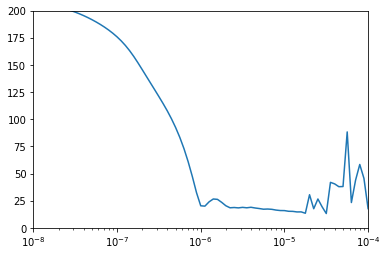

In [215]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 200])

In [216]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
14/14 [==============================]92.6910 - mae: 193.191 - 3s 2s/step - loss: 185.7158 - mae: 186.215 - 3s 1s/step - loss: 180.5347 - mae: 181.034 - 3s 773ms/step - loss: 175.2244 - mae: 175.72 - 3s 623ms/step - loss: 170.4845 - mae: 170.98 - 3s 523ms/step - loss: 166.0178 - mae: 166.51 - 3s 452ms/step - loss: 160.8702 - mae: 161.37 - 3s 399ms/step - loss: 155.0251 - mae: 155.52 - 3s 357ms/step - loss: 148.5370 - mae: 149.03 - 3s 324ms/step - loss: 141.5525 - mae: 142.05 - 3s 296ms/step - loss: 134.0953 - mae: 134.59 - 3s 274ms/step - loss: 126.2354 - mae: 126.73 - 3s 255ms/step - loss: 118.0142 - mae: 118.51 - 3s 238ms/step - loss: 111.3034 - mae: 118.00 - 3s 240ms/step - loss: 111.3034 - mae: 118.0008
Epoch 2/500
14/14 [==============================] - ETA: 0s - loss: 46.8657 - mae: 47.365 - ETA: 0s - loss: 55.9937 - mae: 56.492 - ETA: 0s - loss: 57.1279 - mae: 57.626 - ETA: 0s - loss: 53.0886 - mae: 53.587 - ETA: 0s - loss: 45.4747 - mae: 45.973 - 0s 25ms/step - los

14/14 [==============================] - ETA: 0s - loss: 21.2997 - mae: 21.799 - ETA: 0s - loss: 17.4980 - mae: 17.997 - ETA: 0s - loss: 12.5130 - mae: 13.008 - ETA: 0s - loss: 11.2884 - mae: 11.784 - ETA: 0s - loss: 9.6180 - mae: 10.104 - 0s 20ms/step - loss: 9.6163 - mae: 10.0802
Epoch 55/500
14/14 [==============================] - ETA: 0s - loss: 20.9995 - mae: 21.499 - ETA: 0s - loss: 16.5209 - mae: 17.020 - ETA: 0s - loss: 12.0219 - mae: 12.511 - ETA: 0s - loss: 10.8281 - mae: 11.319 - ETA: 0s - loss: 9.2166 - mae: 9.7077  - 0s 21ms/step - loss: 9.2152 - mae: 9.6882
Epoch 56/500
14/14 [==============================] - ETA: 0s - loss: 21.2605 - mae: 21.760 - ETA: 0s - loss: 15.4728 - mae: 15.971 - ETA: 0s - loss: 11.7721 - mae: 12.267 - ETA: 0s - loss: 10.9171 - mae: 11.413 - ETA: 0s - loss: 9.3288 - mae: 9.8240  - 0s 21ms/step - loss: 9.3272 - mae: 9.8013
Epoch 57/500
14/14 [==============================] - ETA: 0s - loss: 20.6902 - mae: 21.189 - ETA: 0s - loss: 15.9970 - mae: 

14/14 [==============================] - ETA: 0s - loss: 19.7533 - mae: 20.253 - ETA: 0s - loss: 15.8294 - mae: 16.328 - ETA: 0s - loss: 11.1397 - mae: 11.636 - ETA: 0s - loss: 9.8832 - mae: 10.380 - ETA: 0s - loss: 8.3215 - mae: 8.8082 - 0s 24ms/step - loss: 8.3196 - mae: 8.7822
Epoch 109/500
14/14 [==============================] - ETA: 0s - loss: 19.5086 - mae: 20.008 - ETA: 0s - loss: 15.1623 - mae: 15.661 - ETA: 0s - loss: 11.0466 - mae: 11.543 - ETA: 0s - loss: 9.8153 - mae: 10.312 - ETA: 0s - loss: 8.2492 - mae: 8.7339 - 0s 24ms/step - loss: 8.2475 - mae: 8.7103
Epoch 110/500
14/14 [==============================] - ETA: 0s - loss: 19.5975 - mae: 20.097 - ETA: 0s - loss: 15.6231 - mae: 16.122 - ETA: 0s - loss: 10.8838 - mae: 11.379 - ETA: 0s - loss: 9.4848 - mae: 9.9815  - ETA: 0s - loss: 7.9911 - mae: 8.475 - 0s 23ms/step - loss: 7.9894 - mae: 8.4518
Epoch 111/500
14/14 [==============================] - ETA: 0s - loss: 19.3916 - mae: 19.891 - ETA: 0s - loss: 15.0239 - mae: 15.

14/14 [==============================] - ETA: 0s - loss: 18.7863 - mae: 19.286 - ETA: 0s - loss: 15.4330 - mae: 15.932 - ETA: 0s - loss: 10.5761 - mae: 11.062 - ETA: 0s - loss: 9.0533 - mae: 9.5439  - ETA: 0s - loss: 7.5768 - mae: 8.055 - 0s 24ms/step - loss: 7.5752 - mae: 8.0332
Epoch 163/500
14/14 [==============================] - ETA: 0s - loss: 18.6177 - mae: 19.117 - ETA: 0s - loss: 14.6693 - mae: 15.169 - ETA: 0s - loss: 10.3622 - mae: 10.860 - ETA: 0s - loss: 9.1421 - mae: 9.6404  - ETA: 0s - loss: 7.6989 - mae: 8.186 - 0s 25ms/step - loss: 7.6971 - mae: 8.1619
Epoch 164/500
14/14 [==============================] - ETA: 0s - loss: 19.2002 - mae: 19.700 - ETA: 0s - loss: 17.3440 - mae: 17.843 - ETA: 0s - loss: 11.7647 - mae: 12.243 - ETA: 0s - loss: 9.5725 - mae: 10.058 - ETA: 0s - loss: 8.1123 - mae: 8.5889 - 0s 25ms/step - loss: 7.6709 - mae: 8.1256
Epoch 165/500
14/14 [==============================] - ETA: 0s - loss: 18.2154 - mae: 18.715 - ETA: 0s - loss: 14.8000 - mae: 15.

Epoch 217/500
14/14 [==============================] - ETA: 0s - loss: 18.0831 - mae: 18.583 - ETA: 0s - loss: 14.1565 - mae: 14.656 - ETA: 0s - loss: 10.0435 - mae: 10.540 - ETA: 0s - loss: 8.6717 - mae: 9.1696  - ETA: 0s - loss: 7.2684 - mae: 7.750 - 0s 21ms/step - loss: 7.2669 - mae: 7.7296
Epoch 218/500
14/14 [==============================] - ETA: 0s - loss: 18.4922 - mae: 18.992 - ETA: 0s - loss: 15.0131 - mae: 15.513 - ETA: 0s - loss: 10.1684 - mae: 10.646 - ETA: 0s - loss: 8.5178 - mae: 9.0024  - ETA: 0s - loss: 7.1175 - mae: 7.588 - 0s 22ms/step - loss: 7.1158 - mae: 7.5653
Epoch 219/500
14/14 [==============================] - ETA: 0s - loss: 17.3980 - mae: 17.898 - ETA: 0s - loss: 15.4764 - mae: 15.976 - ETA: 0s - loss: 11.8201 - mae: 12.308 - ETA: 0s - loss: 9.3117 - mae: 9.8038  - ETA: 0s - loss: 8.6110 - mae: 9.104 - ETA: 0s - loss: 7.2509 - mae: 7.734 - 0s 27ms/step - loss: 7.2493 - mae: 7.7120
Epoch 220/500
14/14 [==============================] - ETA: 0s - loss: 18.564

Epoch 272/500
14/14 [==============================] - ETA: 0s - loss: 17.7458 - mae: 18.245 - ETA: 0s - loss: 13.3326 - mae: 13.830 - ETA: 0s - loss: 9.4869 - mae: 9.9822  - ETA: 0s - loss: 8.3467 - mae: 8.843 - ETA: 0s - loss: 7.0975 - mae: 7.592 - 0s 21ms/step - loss: 7.0959 - mae: 7.5691
Epoch 273/500
14/14 [==============================] - ETA: 0s - loss: 17.5645 - mae: 18.064 - ETA: 0s - loss: 14.1642 - mae: 14.664 - ETA: 0s - loss: 9.8181 - mae: 10.305 - ETA: 0s - loss: 8.2752 - mae: 8.7662 - ETA: 0s - loss: 7.0214 - mae: 7.509 - 0s 20ms/step - loss: 7.0197 - mae: 7.4857
Epoch 274/500
14/14 [==============================] - ETA: 0s - loss: 17.0381 - mae: 17.538 - ETA: 0s - loss: 13.3556 - mae: 13.853 - ETA: 0s - loss: 9.4878 - mae: 9.9833  - ETA: 0s - loss: 8.0590 - mae: 8.555 - ETA: 0s - loss: 6.7520 - mae: 7.239 - 0s 20ms/step - loss: 6.7505 - mae: 7.2192
Epoch 275/500
14/14 [==============================] - ETA: 0s - loss: 17.8376 - mae: 18.337 - ETA: 0s - loss: 13.6133 - 

Epoch 300/500
14/14 [==============================] - ETA: 0s - loss: 16.8360 - mae: 17.336 - ETA: 0s - loss: 13.2207 - mae: 13.718 - ETA: 0s - loss: 9.3681 - mae: 9.8643  - ETA: 0s - loss: 8.0078 - mae: 8.505 - ETA: 0s - loss: 6.7396 - mae: 7.226 - 0s 20ms/step - loss: 6.7381 - mae: 7.2050
Epoch 301/500
14/14 [==============================] - ETA: 0s - loss: 17.6636 - mae: 18.163 - ETA: 0s - loss: 13.5205 - mae: 14.018 - ETA: 0s - loss: 9.6714 - mae: 10.166 - ETA: 0s - loss: 8.3419 - mae: 8.8383 - ETA: 0s - loss: 7.0435 - mae: 7.533 - 0s 21ms/step - loss: 7.0418 - mae: 7.5096
Epoch 302/500
14/14 [==============================] - ETA: 0s - loss: 17.4067 - mae: 17.906 - ETA: 0s - loss: 14.4675 - mae: 14.967 - ETA: 0s - loss: 9.7406 - mae: 10.222 - ETA: 0s - loss: 8.2019 - mae: 8.6894 - ETA: 0s - loss: 6.8993 - mae: 7.381 - 0s 20ms/step - loss: 6.8976 - mae: 7.3592
Epoch 303/500
14/14 [==============================] - ETA: 0s - loss: 17.1816 - mae: 17.681 - ETA: 0s - loss: 13.3702 - 

14/14 [==============================] - ETA: 0s - loss: 16.9197 - mae: 17.419 - ETA: 0s - loss: 14.2871 - mae: 14.787 - ETA: 0s - loss: 9.6305 - mae: 10.114 - ETA: 0s - loss: 8.1068 - mae: 8.5956 - ETA: 0s - loss: 6.8101 - mae: 7.290 - 0s 22ms/step - loss: 6.8084 - mae: 7.2675
Epoch 354/500
14/14 [==============================] - ETA: 0s - loss: 16.6259 - mae: 17.125 - ETA: 0s - loss: 13.1328 - mae: 13.630 - ETA: 0s - loss: 9.3173 - mae: 9.8028  - ETA: 0s - loss: 7.8868 - mae: 8.376 - ETA: 0s - loss: 6.6205 - mae: 7.096 - 0s 21ms/step - loss: 6.6190 - mae: 7.0759
Epoch 355/500
14/14 [==============================] - ETA: 0s - loss: 17.1287 - mae: 17.628 - ETA: 0s - loss: 13.3659 - mae: 13.863 - ETA: 0s - loss: 9.5101 - mae: 9.9959  - ETA: 0s - loss: 8.0334 - mae: 8.523 - ETA: 0s - loss: 6.7351 - mae: 7.211 - 0s 21ms/step - loss: 6.7337 - mae: 7.1910
Epoch 356/500
14/14 [==============================] - ETA: 0s - loss: 17.4471 - mae: 17.947 - ETA: 0s - loss: 13.8882 - mae: 14.388 - 

14/14 [==============================] - ETA: 0s - loss: 16.2375 - mae: 16.737 - ETA: 0s - loss: 14.6046 - mae: 15.104 - ETA: 0s - loss: 11.6015 - mae: 12.100 - ETA: 0s - loss: 9.3046 - mae: 9.7870  - ETA: 0s - loss: 8.6886 - mae: 9.173 - ETA: 0s - loss: 8.2374 - mae: 8.723 - ETA: 0s - loss: 7.3976 - mae: 7.886 - ETA: 0s - loss: 6.9423 - mae: 7.416 - 1s 46ms/step - loss: 6.5694 - mae: 7.0254
Epoch 408/500
14/14 [==============================] - ETA: 0s - loss: 17.0527 - mae: 17.552 - ETA: 0s - loss: 15.0183 - mae: 15.518 - ETA: 0s - loss: 11.8542 - mae: 12.353 - ETA: 0s - loss: 9.3693 - mae: 9.8447  - ETA: 0s - loss: 8.2547 - mae: 8.735 - ETA: 0s - loss: 7.4137 - mae: 7.897 - ETA: 0s - loss: 6.5768 - mae: 7.049 - 1s 40ms/step - loss: 6.5753 - mae: 7.0282
Epoch 409/500
14/14 [==============================] - ETA: 0s - loss: 16.9047 - mae: 17.404 - ETA: 0s - loss: 14.7726 - mae: 15.272 - ETA: 0s - loss: 11.6578 - mae: 12.156 - ETA: 0s - loss: 9.2577 - mae: 9.7398  - ETA: 0s - loss: 8.1

14/14 [==============================] - ETA: 0s - loss: 16.7164 - mae: 17.216 - ETA: 0s - loss: 14.9320 - mae: 15.432 - ETA: 0s - loss: 11.7234 - mae: 12.222 - ETA: 0s - loss: 9.3066 - mae: 9.7866  - ETA: 0s - loss: 8.1802 - mae: 8.664 - ETA: 0s - loss: 7.3257 - mae: 7.812 - ETA: 0s - loss: 6.5047 - mae: 6.981 - 0s 31ms/step - loss: 6.5031 - mae: 6.9600
Epoch 453/500
14/14 [==============================] - ETA: 0s - loss: 16.4028 - mae: 16.902 - ETA: 0s - loss: 14.5339 - mae: 15.033 - ETA: 0s - loss: 11.2463 - mae: 11.743 - ETA: 0s - loss: 8.5927 - mae: 9.0794  - ETA: 0s - loss: 7.7865 - mae: 8.275 - ETA: 0s - loss: 6.9409 - mae: 7.424 - 0s 30ms/step - loss: 6.5608 - mae: 7.0234
Epoch 454/500
14/14 [==============================] - ETA: 0s - loss: 16.7969 - mae: 17.296 - ETA: 0s - loss: 14.9517 - mae: 15.451 - ETA: 0s - loss: 11.6914 - mae: 12.190 - ETA: 0s - loss: 9.3447 - mae: 9.8254  - ETA: 0s - loss: 8.2206 - mae: 8.705 - ETA: 0s - loss: 7.3880 - mae: 7.875 - ETA: 0s - loss: 6.5

In [217]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

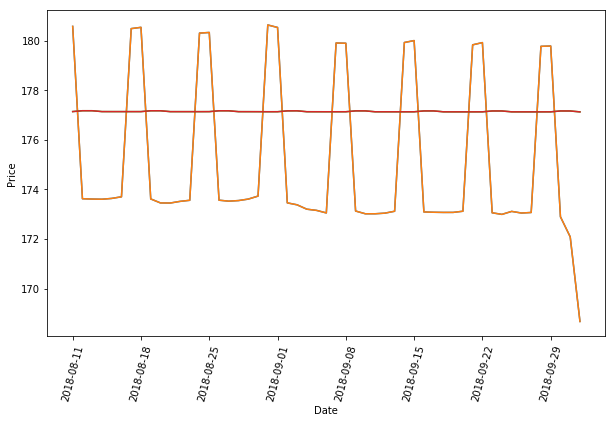

In [218]:
plt.figure(figsize=(10, 6))
plot_series3(time_valid, x_valid)
plot_series3(time_valid, rnn_forecast)

<Figure size 432x288 with 0 Axes>

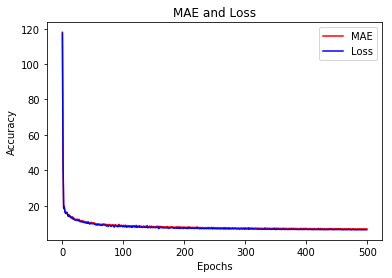

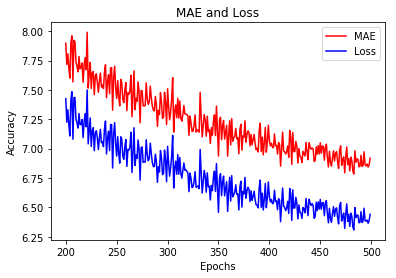

<Figure size 432x288 with 0 Axes>

In [219]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [220]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

3.722304

# Adding a convolutional layer and a deeper dense to the network

In [221]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [222]:
tf.keras.backend.clear_session()
tf.random.set_seed(21)
np.random.seed(21)
window_size = 7
batch_size = 14
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(213,)
Epoch 1/100
15/15 [==============================]63.4631 - mae: 163.963 - 4s 2s/step - loss: 163.7635 - mae: 164.263 - 4s 1s/step - loss: 164.9123 - mae: 165.412 - 4s 932ms/step - loss: 166.0457 - mae: 166.54 - 4s 749ms/step - loss: 167.3309 - mae: 167.83 - 4s 626ms/step - loss: 168.5911 - mae: 169.09 - 4s 539ms/step - loss: 170.1211 - mae: 170.62 - 4s 473ms/step - loss: 171.3368 - mae: 171.83 - 4s 423ms/step - loss: 172.3598 - mae: 172.85 - 4s 382ms/step - loss: 173.0996 - mae: 173.59 - 4s 348ms/step - loss: 173.7271 - mae: 174.22 - 4s 321ms/step - loss: 174.2632 - mae: 174.76 - 4s 297ms/step - loss: 174.7501 - mae: 175.25 - 4s 278ms/step - loss: 175.1347 - mae: 175.63 - 4s 260ms/step - loss: 175.4543 - mae: 175.86 - 4s 262ms/step - loss: 175.4543 - mae: 175.8674
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 162.6502 - mae: 163.150 - ETA: 0s - loss: 167.4542 - m

Epoch 79/100
15/15 [==============================] - ETA: 0s - loss: 33.3355 - mae: 33.835 - ETA: 0s - loss: 21.2049 - mae: 21.698 - 0s 10ms/step - loss: 19.3879 - mae: 20.0217
Epoch 80/100
15/15 [==============================] - ETA: 0s - loss: 52.6062 - mae: 53.106 - ETA: 0s - loss: 26.7347 - mae: 27.232 - 0s 10ms/step - loss: 19.6187 - mae: 19.6917
Epoch 81/100
15/15 [==============================] - ETA: 0s - loss: 11.6303 - mae: 12.130 - ETA: 0s - loss: 22.4009 - mae: 22.900 - ETA: 0s - loss: 22.4772 - mae: 22.977 - 0s 11ms/step - loss: 22.5350 - mae: 23.8440
Epoch 82/100
15/15 [==============================] - ETA: 0s - loss: 54.8167 - mae: 55.316 - ETA: 0s - loss: 26.3007 - mae: 26.796 - 0s 10ms/step - loss: 26.5211 - mae: 26.8255
Epoch 83/100
15/15 [==============================] - ETA: 0s - loss: 56.4104 - mae: 56.910 - ETA: 0s - loss: 34.5298 - mae: 35.029 - 0s 10ms/step - loss: 34.6729 - mae: 34.7216
Epoch 84/100
15/15 [==============================] - ETA: 0s - loss: 

[1e-08, 0.0001, 0, 60]

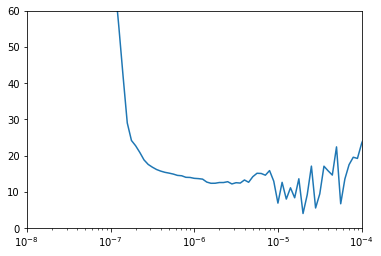

In [223]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [224]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
2/2 [==============================] 179.6202 - mae: 180.120 - 4s 2s/step - loss: 175.6962 - mae: 177.401 - 4s 2s/step - loss: 175.6962 - mae: 177.4016
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 137.4237 - mae: 137.923 - 0s 114ms/step - loss: 135.2492 - mae: 133.5747
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 113.2048 - mae: 113.704 - 0s 106ms/step - loss: 113.0814 - mae: 113.4579
Epoch 4/500
2/2 [==============================] - ETA: 0s - loss: 99.2449 - mae: 99.744 - 0s 102ms/step - loss: 98.9028 - mae: 99.0608
Epoch 5/500
2/2 [==============================] - ETA: 0s - loss: 82.7512 - mae: 83.251 - 0s 106ms/step - loss: 82.1871 - mae: 82.1230
Epoch 6/500
2/2 [==============================] - ETA: 0s - loss: 66.2228 - mae: 66.722 - 0s 97ms/step - loss: 66.0228 - mae: 66.3229
Epoch 7/500
2/2 [==============================] - ETA: 0s - loss: 51.9925 - mae: 52.492 - 0s 116ms/step - loss: 51.8499 - mae: 52.2072
Epoch 8/500
2

Epoch 62/500
2/2 [==============================] - ETA: 0s - loss: 7.7772 - mae: 8.218 - 0s 93ms/step - loss: 7.3937 - mae: 7.4217
Epoch 63/500
2/2 [==============================] - ETA: 0s - loss: 7.7807 - mae: 8.217 - 0s 101ms/step - loss: 7.3778 - mae: 7.3850
Epoch 64/500
2/2 [==============================] - ETA: 0s - loss: 7.7283 - mae: 8.160 - 0s 107ms/step - loss: 7.3274 - mae: 7.3357
Epoch 65/500
2/2 [==============================] - ETA: 0s - loss: 7.7509 - mae: 8.187 - 0s 98ms/step - loss: 7.3193 - mae: 7.2936
Epoch 66/500
2/2 [==============================] - ETA: 0s - loss: 7.7209 - mae: 8.162 - 0s 102ms/step - loss: 7.2982 - mae: 7.2861
Epoch 67/500
2/2 [==============================] - ETA: 0s - loss: 7.7069 - mae: 8.147 - 0s 99ms/step - loss: 7.2816 - mae: 7.2673
Epoch 68/500
2/2 [==============================] - ETA: 0s - loss: 7.6353 - mae: 8.067 - 0s 103ms/step - loss: 7.2182 - mae: 7.2089
Epoch 69/500
2/2 [==============================] - ETA: 0s - loss: 7.63

2/2 [==============================] - ETA: 0s - loss: 6.1718 - mae: 6.601 - 0s 94ms/step - loss: 5.7296 - mae: 5.6882
Epoch 185/500
2/2 [==============================] - ETA: 0s - loss: 6.1803 - mae: 6.615 - 0s 93ms/step - loss: 5.7368 - mae: 5.6985
Epoch 186/500
2/2 [==============================] - ETA: 0s - loss: 6.1815 - mae: 6.611 - 0s 93ms/step - loss: 5.7330 - mae: 5.6871
Epoch 187/500
2/2 [==============================] - ETA: 0s - loss: 6.0714 - mae: 6.497 - 0s 92ms/step - loss: 5.6661 - mae: 5.6614
Epoch 188/500
2/2 [==============================] - ETA: 0s - loss: 6.1140 - mae: 6.542 - 0s 104ms/step - loss: 5.6875 - mae: 5.6628
Epoch 189/500
2/2 [==============================] - ETA: 0s - loss: 6.1100 - mae: 6.537 - 0s 93ms/step - loss: 5.6814 - mae: 5.6537
Epoch 190/500
2/2 [==============================] - ETA: 0s - loss: 6.1281 - mae: 6.556 - 0s 98ms/step - loss: 5.6857 - mae: 5.6440
Epoch 191/500
2/2 [==============================] - ETA: 0s - loss: 6.0456 - mae:

2/2 [==============================] - ETA: 0s - loss: 5.5604 - mae: 6.001 - 0s 96ms/step - loss: 5.0944 - mae: 5.0404
Epoch 307/500
2/2 [==============================] - ETA: 0s - loss: 5.4257 - mae: 5.851 - 0s 96ms/step - loss: 5.0383 - mae: 5.0640
Epoch 308/500
2/2 [==============================] - ETA: 0s - loss: 5.4795 - mae: 5.907 - 0s 94ms/step - loss: 5.0291 - mae: 4.9821
Epoch 309/500
2/2 [==============================] - ETA: 0s - loss: 5.4801 - mae: 5.913 - 0s 93ms/step - loss: 5.0629 - mae: 5.0568
Epoch 310/500
2/2 [==============================] - ETA: 0s - loss: 5.4327 - mae: 5.857 - 0s 99ms/step - loss: 5.0038 - mae: 4.9754
Epoch 311/500
2/2 [==============================] - ETA: 0s - loss: 5.5079 - mae: 5.944 - 0s 97ms/step - loss: 5.0635 - mae: 5.0274
Epoch 312/500
2/2 [==============================] - ETA: 0s - loss: 5.4359 - mae: 5.861 - 0s 118ms/step - loss: 5.0215 - mae: 5.0136
Epoch 313/500
2/2 [==============================] - ETA: 0s - loss: 5.5006 - mae:

2/2 [==============================] - ETA: 0s - loss: 5.1596 - mae: 5.586 - 0s 101ms/step - loss: 4.7257 - mae: 4.6956
Epoch 429/500
2/2 [==============================] - ETA: 0s - loss: 5.1988 - mae: 5.631 - 0s 98ms/step - loss: 4.7841 - mae: 4.7798
Epoch 430/500
2/2 [==============================] - ETA: 0s - loss: 5.1527 - mae: 5.578 - 0s 98ms/step - loss: 4.7240 - mae: 4.6957
Epoch 431/500
2/2 [==============================] - ETA: 0s - loss: 5.1770 - mae: 5.609 - 0s 93ms/step - loss: 4.7572 - mae: 4.7431
Epoch 432/500
2/2 [==============================] - ETA: 0s - loss: 5.1465 - mae: 5.570 - 0s 92ms/step - loss: 4.7286 - mae: 4.7115
Epoch 433/500
2/2 [==============================] - ETA: 0s - loss: 5.1991 - mae: 5.634 - 0s 103ms/step - loss: 4.7630 - mae: 4.7350
Epoch 434/500
2/2 [==============================] - ETA: 0s - loss: 5.1126 - mae: 5.537 - 0s 97ms/step - loss: 4.7240 - mae: 4.7430
Epoch 435/500
2/2 [==============================] - ETA: 0s - loss: 5.1609 - mae

In [225]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

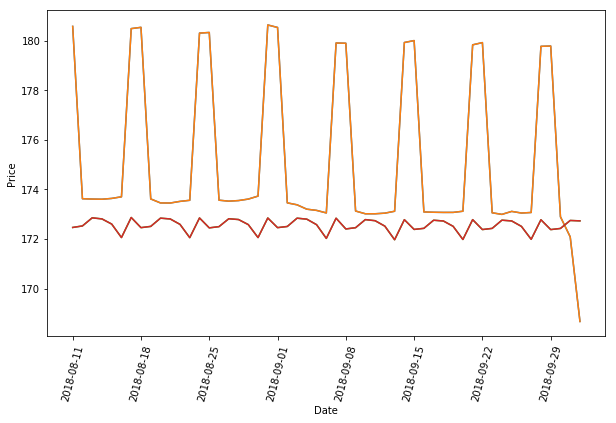

In [226]:
plt.figure(figsize=(10, 6))
plot_series3(time_valid, x_valid)
plot_series3(time_valid, rnn_forecast)

<Figure size 432x288 with 0 Axes>

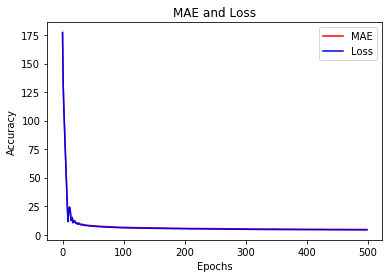

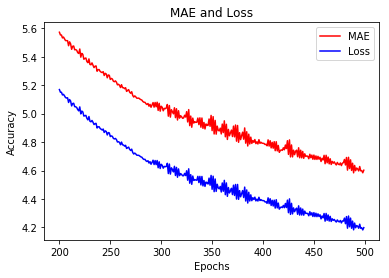

<Figure size 432x288 with 0 Axes>

In [227]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

The noisy behavior on the second plot could indicate a bad choice of window size, which I highly doubt

In [228]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.7560346